# 1. Vehicle Routing Problem (VRP) demo with OSMnx and OR-Tools

This repository demonstrates the usage of [OR-Tools](https://developers.google.com/optimization) and [OSMnx](https://github.com/gboeing/osmnx).

## What is VRP?
Vehicle Routing Problem (VRP) is a combinatorial optimization problem that involves finding the optimal set of routes for a fleet of vehicles to visit a set of locations, subject to various constraints. It is a well-known problem in the field of operations research and has many practical applications such as logistics, transportation, and supply chain management.

## What is OR-Tools?
OR-Tools is an open-source software suite for optimization developed by Google. It includes a wide range of solvers and tools for solving various types of optimization problems, including VRP.

## What is OSMnx?
OSMnx is a Python library for working with [OpenStreetMap](https://www.openstreetmap.org/) (OSM) data. It allows you to download OSM data, visualize it, and perform various spatial analyses on it. In this notebook, we will use OSMnx to download street network data for a specific location.

## What is the goal of this notebook?
The goal of this notebook is to demonstrate how to solve a VRP using OR-Tools and OSMnx. Specifically, we will use OSMnx to download street network data for a specific location, and then use OR-Tools to find the optimal set of routes for a fleet of vehicles to visit a set of bus stops in that location, subject to various constraints such as vehicle capacity and maximum distance traveled. Finally, we will visualize the results on a map using folium. This notebook is intended for anyone who is interested in learning about VRP, OR-Tools, and OSMnx, regardless of their level of expertise in these areas.

## Next goal
Penambahan capasitas kendaraan, time windows

In [212]:
pip install contextily

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# Import necessary packages
import contextily as ctx
import folium
import geopy.distance
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from operator import itemgetter
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [214]:
# Specify the center location (latitude, longtitude)
CENTER_LOCATION = (-6.255072,	106.797413)

# Specify distance in meters
DIST = 10000

# Specify the number of vehicles
NUM_VEHICLES = 4

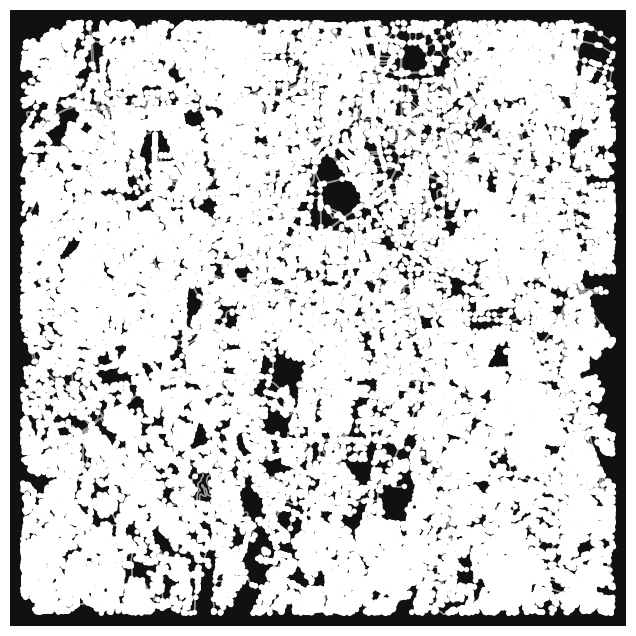

In [215]:
# Get the highway graph
G = ox.graph_from_point(CENTER_LOCATION, dist=DIST, network_type='drive')
*_, = ox.plot_graph(G)

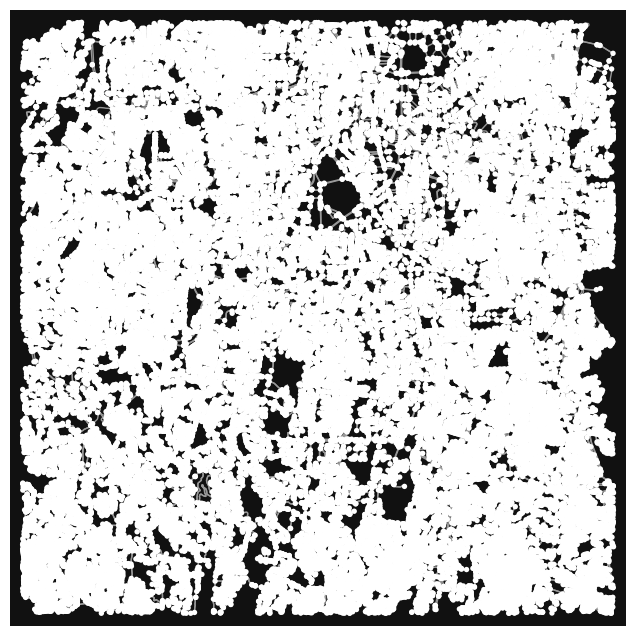

In [216]:
# Remove unreachable nodes from the graph
G = ox.utils_graph.get_largest_component(G, strongly=True)
*_, = ox.plot_graph(G)

In [290]:
# Use the nearest node to the center location as the depot
depot = ox.distance.nearest_nodes(G, CENTER_LOCATION[1], CENTER_LOCATION[0])
depot

330013695

In [218]:
G

In [219]:
# Load data
import pandas as pd
data = pd.read_csv("Data_Alfamart Indomaret_South Jakarta_Filtered.csv")


In [220]:
# Rename columns
data.rename(columns={'longitude': 'lng'}, inplace=True)
data.rename(columns={'latitude': 'lat'}, inplace=True)

In [221]:
# Lakukan pengelompokan dan hitung median
district_tebet = data.groupby('place_id')[['lat', 'lng']].median().reset_index()

# Ubah nama kolom menjadi sesuai dengan yang diharapkan
district_tebet.columns = ['place_id', 'lat', 'lng']

# Tampilkan lima baris pertama
district_tebet

,place_id,lat,lng
0,ChIJ-6Meqf_xaS4R99u9vNNVFjg,-6.297004,106.815418
1,ChIJ4T8PLOPzaS4RQDVcYaC-IGg,-6.226964,106.821372
2,ChIJCZIzrZ_xaS4RiJX_wvOeaH4,-6.257676,106.796800
3,ChIJLWcbOM_xaS4RIMEFJuZjRvY,-6.285777,106.780884
4,ChIJN7p70X7xaS4R6VpOujMI_Wo,-6.255553,106.812338
5,ChIJPz4W5BPvaS4RoUnKBAiaL3o,-6.307003,106.793690
6,ChIJSXpPIvDzaS4RKSuxd1gXm2Q,-6.261301,106.828974
7,ChIJTYdPFlzzaS4R4JoaMHSAiPY,-6.224620,106.840175
8,ChIJWdlCSXPuaS4RzpIWwflyKKU,-6.320362,106.810676
9,ChIJaxj8TyDuaS4RmJ8rDkpB2GA,-6.302203,106.791936


In [222]:
# Find bus stops
bus_stops = []
for idx, row in district_tebet.iterrows():
    bus_stop = (row['lat'], row['lng'])
    bus_stops.append(bus_stop)

In [223]:
import osmnx as ox
from operator import itemgetter
from scipy.spatial import distance

In [224]:
# Find nearest nodes to bus stops
node_stop = []
for bus_stop in bus_stops:
    nearest_node = None
    min_dist = float('inf')
    for node, data in G.nodes(data=True):
        dist = distance.euclidean((data['y'], data['x']), bus_stop)
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    node_stop.append(nearest_node)

print(node_stop[:5])

[2245209305, 353136643, 356236075, 7474127324, 3787028858]


In [225]:
# Find bus stops
#bus_stops = ox.geometries_from_point(CENTER_LOCATION, {"highway": "bus_stop"}, dist=DIST)

# Get the nearest nodes to bus stops
#bus_stop_nodes = list(map(itemgetter(1), bus_stops.index.values))
#bus_stop_nodes[:5]

In [355]:
# Combine depot and bus_stops
nodes = [depot] + node_stop
nodes[:5]

[2245209305, 2245209305, 5495410324, 353136643, 356236075]

In [227]:
import geopy.distance

In [228]:
# Add bus stops to the highway graph
for idx, bus_stop in district_tebet.iterrows():
    # Temukan node terdekat di graf G
    nearest_node = ox.distance.nearest_nodes(G, bus_stop['lng'], bus_stop['lat'])
    
    # Hitung jarak antara node terdekat dan titik bus
    distance = geopy.distance.distance((G.nodes[nearest_node]['y'], G.nodes[nearest_node]['x']), (bus_stop['lat'], bus_stop['lng']))
    
    # Tambahkan node bus stop ke graf
    G.add_node(bus_stop['place_id'], x=bus_stop['lng'], y=bus_stop['lat'])
    
    # Tambahkan edge dari node terdekat ke node bus stop (bidirectional)
    G.add_edge(nearest_node, bus_stop['place_id'], weight=distance.m)
    G.add_edge(bus_stop['place_id'], nearest_node, weight=distance.m)

# Get edges as GeoDataFrames
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges.head(19)

osmid   
u        v          key                                                      
29938969 5227846481 0                                            450695543  \
         4488259599 0                                           1252511139   
         309914752  0                             [1249895912, 1252511139]   
29938988 191578995  0                                             18056345   
         3697659047 0                                 [18577337, 68558044]   
29938990 4338794099 0                                             68558044   
         315469588  0                                             28696798   
29939005 4464981103 0                                            449551314   
         4464981122 0                               [416531705, 594116154]   
29939007 29939005   0                                           1239781918   
29939013 186849390  0                                             28706142   
         186849140  0                                            630151200   
29939017 4603230704 0                    [594893744, 497570444, 776168589]   
29939019 315546959  0                                             28705496   
         29939017   0                                            501941636   
29939033 4548266917 0    [681333443, 225385542, 717451601, 743000050, 4...   
29939151 29939154   0                                              4705043   
29939154 4996688467 0                               [560884338, 510722278]   
         1163404618 0                                            762101021   

                        oneway   lanes                          name   
u        v          key                                                
29938969 5227846481 0     True       3  Jalan Mohammad Husni Thamrin  \
         4488259599 0    False       3                           NaN   
         309914752  0    False       3                           NaN   
29938988 191578995  0     True       3             Jalan Kebon Sirih   
         3697659047 0     True       1                   Jalan Jaksa   
29938990 4338794099 0     True       1                   Jalan Jaksa   
         315469588  0    False       2     Jalan Kebon Sirih Barat I   
29939005 4464981103 0     True       4               Jalan Majapahit   
         4464981122 0     True       3                           NaN   
29939007 29939005   0     True       4     Jalan Medan Merdeka Utara   
29939013 186849390  0     True       2                           NaN   
         186849140  0     True       3                 Jalan Veteran   
29939017 4603230704 0     True       3                 Jalan Veteran   
29939019 315546959  0     True       2                Jalan Katedral   
         29939017   0     True       2                 Jalan Veteran   
29939033 4548266917 0     True  [3, 4]                 Jalan Perwira   
29939151 29939154   0     True       1       Jalan Gunung Sahari III   
29939154 4996688467 0    False       1       Jalan Gunung Sahari III   
         1163404618 0     True       4      Jalan Gunung Sahari Raya   

                                highway width reversed   length  junction   
u        v          key                                                     
29938969 5227846481 0           primary  16.7    False    8.960       NaN  \
         4488259599 0           primary   NaN    False   35.884  circular   
         309914752  0           primary   NaN     True   18.583  circular   
29938988 191578995  0           primary     9    False   89.477       NaN   
         3697659047 0       residential     3    False  187.436       NaN   
29938990 4338794099 0       residential     3    False   31.919       NaN   
         315469588  0       residential     5    False  214.430       NaN   
29939005 4464981103 0           primary     9    False   61.549       NaN   
         4464981122 0      primary_link     6    False   87.795       NaN   
29939007 29939005   0           primary     6    False  217.248       

In [229]:
# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(nodes), NUM_VEHICLES, nodes.index(depot))

# Create routing model
routing = pywrapcp.RoutingModel(manager)

In [230]:
# Define distance callback
def distance_callback(from_node_index, to_node_index):
    from_node = nodes[manager.IndexToNode(from_node_index)]
    to_node = nodes[manager.IndexToNode(to_node_index)]
    return nx.shortest_path_length(G, from_node, to_node)

# Register distance callback
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [231]:
# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    3000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name
)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

In [232]:
# Set path-cheapest-arc search strategy
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

In [233]:
# Print the solution
total_distance = 0
for vehicle_id in range(NUM_VEHICLES):
    index = routing.Start(vehicle_id)
    route_distance = 0
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
    route.append(manager.IndexToNode(index))
    print(f"Route for vehicle {vehicle_id}:\n{' -> '.join(str(node) for node in route)}")
    print(f"Distance of route: {route_distance}m\n")
    total_distance += route_distance
print(f"Total distance of all routes: {total_distance}m")

Route for vehicle 0:
0 -> 13 -> 20 -> 4 -> 12 -> 3 -> 0
Distance of route: 188m

Route for vehicle 1:
0 -> 19 -> 6 -> 10 -> 16 -> 14 -> 5 -> 0
Distance of route: 195m

Route for vehicle 2:
0 -> 2 -> 15 -> 17 -> 8 -> 7 -> 0
Distance of route: 201m

Route for vehicle 3:
0 -> 11 -> 9 -> 1 -> 18 -> 0
Distance of route: 178m

Total distance of all routes: 762m


In [234]:
import folium

# Buat DataFrame dari list bus_stops
bus_stops_df = pd.DataFrame(bus_stops, columns=['lat', 'lng'])

# Create map object
m = folium.Map(location=CENTER_LOCATION, zoom_start=16)

# Plot depot
depot_coords = (G.nodes[depot]['y'], G.nodes[depot]['x'])
folium.Marker(location=depot_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {depot_coords}").add_to(m)

# Plot bus stops
for index, bus_stop in bus_stops_df.iterrows():
    stop_coords = (bus_stop['lat'], bus_stop['lng'])
    folium.Marker(location=stop_coords, icon=folium.Icon(color='green', icon='circle', prefix='fa'), tooltip=f"Pemberhentian {stop_coords}").add_to(m)

In [235]:
import folium

# Buat DataFrame dari list bus_stops
bus_stops_df = pd.DataFrame(bus_stops, columns=['lat', 'lng'])

# Create map object
m = folium.Map(location=CENTER_LOCATION, zoom_start=16)

# Plot depot
depot_coords = (G.nodes[depot]['y'], G.nodes[depot]['x'])
folium.Marker(location=depot_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {depot_coords}").add_to(m)

# Plot bus stops
for index, bus_stop in bus_stops_df.iterrows():
    stop_coords = (bus_stop['lat'], bus_stop['lng'])
    folium.Marker(location=stop_coords, icon=folium.Icon(color='green', icon='circle', prefix='fa'), tooltip=f"Pemberhentian {stop_coords}").add_to(m)
# Create colors for routes
colors = ['blue', 'orange', 'yellow', 'green']

In [349]:
depot_coords

(-6.2551996, 106.7971495)

In [352]:
depot

2245209305

In [236]:
# Plot routes
for vehicle_id in range(NUM_VEHICLES):
    index = routing.Start(vehicle_id)
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(nodes[node_index])
        index = solution.Value(routing.NextVar(index))
    route.append(nodes[manager.IndexToNode(index)])
    color = colors[vehicle_id % NUM_VEHICLES]
    # Create a list of line segments for the route
    segments = []
    for i in range(len(route)-1):
        # Get shortest path between nodes
        path = nx.shortest_path(G, route[i], route[i + 1], weight='length')
        # Add line segment to list
        segments.append([(G.nodes[node]['y'], G.nodes[node]['x']) for node in path])
    # Create polyline from line segments and add to map
    for segment in segments:
        folium.PolyLine(locations=segment, color=color, weight=5).add_to(m)

# Display map
m